# CNN Tutorial on Fashion MNIST Data Set


This turorial gives a breif intro on using CNN for train and prediction (i.e. inference)

## Let's Load Some Packages

In [1]:
using MLDatasets
using NumNN
using Plots
gr()

Plots.GRBackend()

### Temp for ProgressMeter.jl Package

**Uncomment the following line if you run this code for the first time***

In [2]:
# ] add https://github.com/timholy/ProgressMeter.jl.git ;

In [3]:
using ProgressMeter
ProgressMeter.ijulia_behavior(:clear);

### Load the Train/Test Data/Labels

In [4]:
X_train, Y_train = FashionMNIST.traindata(Float64);
X_test, Y_test = FashionMNIST.testdata(Float64);

### Let's Prepare the data/labels

Since the shape of the MNIST data is `(28,28,size)` and to use it in CNN 2D it must be as 4D Array

In [5]:
using SigmoidNumbers
# P1 = Posit{16,0}
P1 = Posit{16,1}

Base.convert(::Type{P}, b::Bool) where {P <: Posit} = P.(Float64(b))
Posit{N,ES}(b::Bool) where {N,ES} = convert(Posit{N,ES}, b)
Base.exp(a::P) where {P <: Posit} = P.(exp(Float64(a)))
Base.promote_rule(::Type{P}, ::Type{IE}) where {P <: Posit, IE <: Base.IEEEFloat} = P

In [6]:
X_train = P1.(reshape(X_train, (size(X_train)[1:2]..., 1, size(X_train)[end])))
X_test = P1.(reshape(X_test, (size(X_test)[1:2]...,1,size(X_test)[end])))

Y_train = oneHot(Y_train)
Y_test = oneHot(Y_test);

### Define the Layers

In [7]:
X_Input = Input(X_train)
X = Conv2D(10, (3,3))(X_Input)
X = BatchNorm(dim=3)(X) #to normalize across the channels
X = Activation(:relu)(X)
X = MaxPool2D((2,2))(X)
X = Conv2D(20, (5,5))(X)
X = BatchNorm(dim=3)(X)
X = Activation(:relu)(X)
X = AveragePool2D((3,3))(X)
X = Flatten()(X)
X_Output = FCLayer(10, :softmax)(X);

Another way when there is no side branches is to use the `chain` function as follows:

```julia
X_Input, X_Ouput = chain(X_train,[Conv2D(10, (3,3)),
                                  BatchNorm(dim=3),
                                  Activation(:relu),
                                  MaxPool2D((2,2)),
                                  Conv2D(20, (5,5)),
                                  BatchNorm(dim=3),
                                  Activation(:relu),
                                  AveragePool2D((3,3)),
                                  Flatten(),
                                  FCLayer(10,:softmax)]);
```

`chain` returns a `Tuple` of two pointers of the Input `Layer` and Output `Layer`

### Let's Define Our Model

This will also initialize the `Layer`s' parameters

In [8]:
model = Model(X_train,Y_train,X_Input,X_Output, 0.005; optimizer=:adam, paramsDtype=P1);

#### Let's use `predict` to see the current Accuracy


In [9]:
TestP = predict(model, X_test, Y_test; NNlib=false, img2col=false);

println()
println("The accuracy of Test Data before the training process $(round(TestP[:accuracy], digits=4))")
println("The cost of Test Data before the training process $(round(TestP[:cost], digits=4))")

Progress: 100%|█████████████████████████████████████████| Time: 0:01:36
  Instances 10000:  10000



The accuracy of Test Data before the training process 0.0722
The cost of Test Data before the training process 2.3143


In [10]:
TrainP = predict(model, X_train, Y_train; NNlib=false, img2col=false);

println()
println("The accuracy of Train Data before the training process $(round(TrainP[:accuracy], digits=4))")
println("The cost of Train Data before the training process $(round(TrainP[:cost], digits=4))")

Progress: 100%|█████████████████████████████████████████| Time: 0:08:08
  Instances 60000:  60000



The accuracy of Train Data before the training process 0.0712
The cost of Train Data before the training process 2.3143


## Train the model

In [11]:
TrainD = train(X_train, Y_train, model, 10; NNlib=false, img2col=false);# testData = X_test, testLabels = Y_test);

Progress: 100%|█████████████████████████████████████████| Time: 9:14:26
  Epoch 10:         10
  Instances 60000:  60000
  Train Cost:       0.2494
  Train Accuracy:   0.9098


`train` function provides an extra `kwargs` to use test Data/Labels to get the Costs and Accuracies during each training epoch. 

**Note** This will take extra time to do the training

Instead it can be used as follows:

```julia
TrainD = train(X_train, Y_train, model, 10)
```

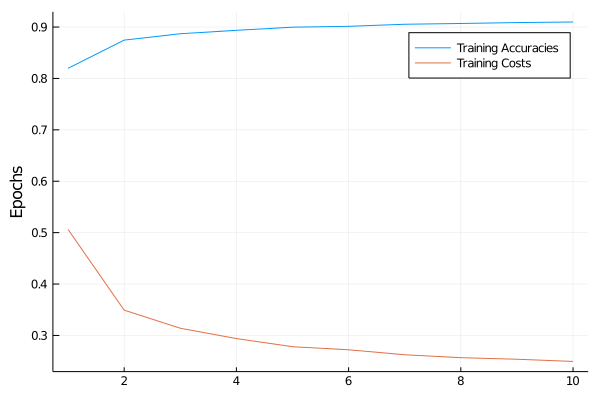

In [15]:
plot(1:10, TrainD[:trainAccuracies], label="Training Accuracies")
plot!(1:10, TrainD[:trainCosts], label="Training Costs")
# plot!(1:10, TrainD[:testAccuracies], label="Test Accuracies")
# plot!(1:10, TrainD[:testCosts], label="Test Costs")
ylabel!("Epochs")

### Predict After Training

In [13]:
TrainP = predict(model, X_train, Y_train);

println()
println("The accuracy of Train Data before the training process $(round(TrainP[:accuracy], digits=4))")
println("The cost of Train Data before the training process $(round(TrainP[:cost], digits=4))")

Progress: 100%|█████████████████████████████████████████| Time: 0:21:00
  Instances 60000:  60000



The accuracy of Train Data before the training process 0.906
The cost of Train Data before the training process 0.2576


In [14]:
TestP = predict(model, X_test, Y_test);

println()
println("The accuracy of Test Data before the training process $(round(TestP[:accuracy], digits=4))")
println("The cost of Test Data before the training process $(round(TestP[:cost], digits=4))")

Progress: 100%|█████████████████████████████████████████| Time: 0:03:28
  Instances 10000:  10000



The accuracy of Test Data before the training process 0.8896
The cost of Test Data before the training process 0.3192
